In [42]:
import os
import importlib
import torch
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from src.data.data_loader import DataLoader, DataLoaderConfig
from src.data.utils import *

In [26]:
output_path = f'{os.environ["DATADIR"]}/test_circle_world'
data_directory = f'{output_path}/raw_data/21-02-15_17-03-55_expert'
config_dict = {
            'data_directories': [data_directory],
            'output_path': output_path,
        }
config = DataLoaderConfig().create(config_dict=config_dict)

data_loader = DataLoader(config=config)
data_loader.load_dataset()
dataset = data_loader.get_dataset()


data_loader - INFO - Started.
data_loader - INFO - Loaded 321 data points from 1 directories


In [54]:
# 1. extract local (or relative) error point from poses and waypoints
waypoints = load_data_from_file(data_directory + '/info_current_waypoint.data')[1]
poses = load_data_from_file(data_directory + '/info_position.data')[1]
global_errors = []
local_errors = []
for w, p in zip(waypoints, poses):
    global_error = torch.zeros((3,))
    global_error[0] = w[0] - p[0]
    global_error[1] = w[1] - p[1]
    global_error[2] = w[2] - p[2]
    global_errors.append(global_error)
    # orientation = rotation from drone to global
    roll, pitch, yaw = R.from_quat((p[3],p[4],p[5],p[6])).as_euler('XYZ')
    # only compensate for yaw (working in global_yaw frame)
    # negative yaw as we're rotating from global to drone frame.
    rotation_global_drone = R.from_euler('XYZ', (0, 0, -yaw), degrees=False).as_matrix()
    local_error = torch.as_tensor(np.matmul(rotation_global_drone, global_error.numpy()))
    local_errors.append(local_error)

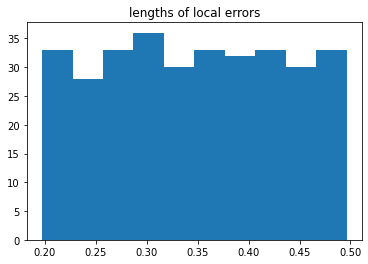

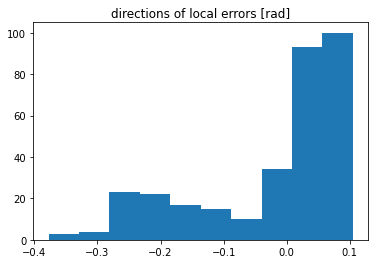

In [77]:
# 2. normalize relative direction to have a fixed distance

# check relative goal distance distribution ==> uniform
lengths = [np.sqrt(p[0]**2 + p[1]**2 + p[2]**2).item() for p in local_errors]
plt.hist(lengths, bins=10)
plt.title('lengths of local errors')
plt.show()

# constant distance should be interpolated between consecutive waypoints:
# this might be harder than it seems... so continue solely with relative directions.

directions = [np.arctan(p[1].item() / p[0].item()) for p in local_errors]
plt.hist(directions, bins=10)
plt.title('directions of local errors [rad]')
plt.show()


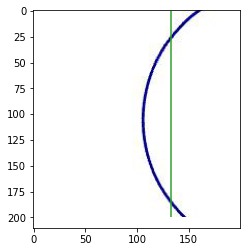

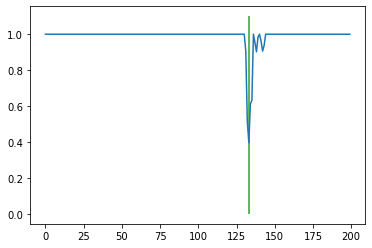

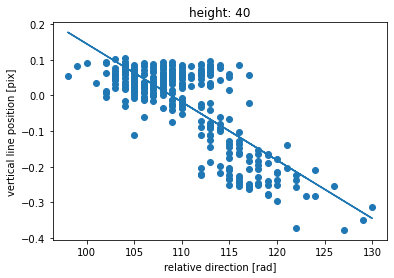

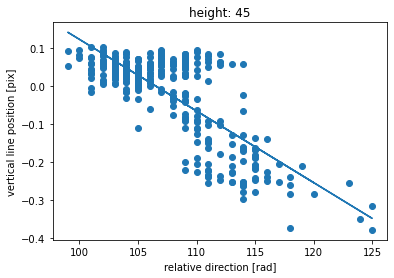

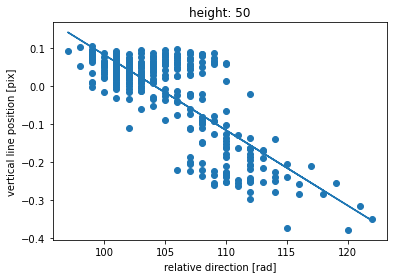

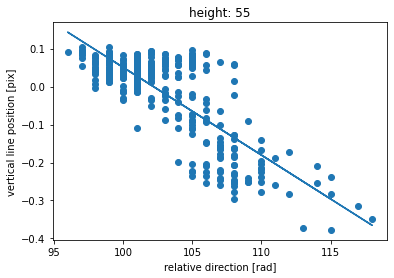

a -0.01978900271767159, b: 2.0609850202059086 of direction = a * crossing + b


In [105]:
# 3. map upper quarter of crossing with relative direction


if True:
    image = dataset.observations[0].permute(1, 2, 0).numpy()
    crossing = np.argmin(image[25, :, 2])

    plt.imshow(image)
    plt.vlines(crossing, ymin=0, ymax=200, color='C2')
    plt.show()
    plt.plot(image[25, :, 2])
    plt.vlines(crossing, ymin=0, ymax=1.1, color='C2')
    plt.show()

if True:
#    for height in range(0, 100, 5):
    for height in range(40, 60, 5):
        # detect crossings
        crossings = np.asarray([float(np.argmin(image.permute(1, 2, 0).numpy()[height, :, 2])) for image in dataset.observations])

        # correlate with directions
        plt.scatter(crossings, directions)
        m, b = np.polyfit(crossings, directions, 1)
        plt.plot(crossings, m*crossings + b)
        plt.xlabel('relative direction [rad]')
        plt.ylabel('vertical line position [pix]')
        plt.title(f'height: {height}')
        plt.show()
height = 50
crossings = np.asarray([float(np.argmin(image.permute(1, 2, 0).numpy()[height, :, 2])) for image in dataset.observations])

# 4. extract derivative for linear projection
m, b = np.polyfit(crossings, directions, 1)
#estimated_direction = m * crossing + b
print(f'a {m}, b: {b} of direction = a * crossing + b')

# 5. (outside of this notebook): combine direction extractor



In [16]:




# 6e. redo steps with big line dataset?


2

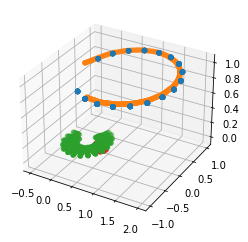

In [63]:
# draw data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=[_[0] for _ in waypoints],
          ys=[_[1] for _ in waypoints],
          zs=[_[2] for _ in waypoints],
          color='C0')

ax.scatter(xs=[_[0] for _ in poses],
          ys=[_[1] for _ in poses],
          zs=[_[2] for _ in poses],
          color='C1')


ax.scatter(xs=[_[0] for _ in global_errors],
           ys=[_[1] for _ in global_errors],
           zs=[_[2] for _ in global_errors],
          color='C2')

ax.scatter(xs=[_[0] for _ in local_errors],
          ys=[_[1] for _ in local_errors],
          zs=[_[2] for _ in local_errors],
          color='C3')

plt.show()